In [2]:
# Trick to import local code:
import sys
sys.path.append("../src")

In [3]:
import rasterio as rio
import numpy as np
from matplotlib import pyplot
from sensorsio import sentinel2, utils

# Creating a dataset

Constructor of ```sentinel2.Sentinel2``` class reads the path to the ***Sentinel2 L2A*** product:

In [4]:
dataset = sentinel2.Sentinel2('/work/datalake/S2-L2A-THEIA/18TXS/2023/07/19/SENTINEL2B_20230719-160022-982_L2A_T18TXS_C_V3-1/')

Printing the returned objects gives basic information on the product:

In [5]:
print(dataset)

SENTINEL2B, 2023-07-19 00:00:00, 18TXS


Among the object attributes, one can find information on acquisition date as a ```datetime.datetime``` object, acquisition year, and day of year:

In [6]:
print(f"date: {dataset.date}, year: {dataset.year}, day of year: {dataset.day_of_year}")

date: 2023-07-19 00:00:00, year: 2023, day of year: 200


One can also read the satellite id, the MGRS tile id and the corresponding coordinate reference system:

In [7]:
print(f"Satellite: {dataset.satellite.value}, MGRS tile: {dataset.tile}, CRS: {dataset.crs}")

Satellite: SENTINEL2B, MGRS tile: 18TXS, CRS: EPSG:32618


Last, the object also contains the geographic bounds expressed in the given CRS.

In [8]:
print(f"Product bounds: {dataset.bounds}")

Product bounds: BoundingBox(left=600000.0, bottom=5090220.0, right=709800.0, top=5200020.0)


# Basic reading

## Reading to numpy

### Selecting bands

```sentinel2.Sentinel2.GROUP_10M``` is a convenient variable to select all 10m bands:

In [9]:
sentinel2.Sentinel2.GROUP_10M

[<Band.B2: 'B2'>, <Band.B3: 'B3'>, <Band.B4: 'B4'>, <Band.B8: 'B8'>]

In a similar way, ```sentinel2.Sentinel2.GROUP_20M``` and ```sentinel2.Sentinel2.GROUP_60M``` exist:

In [10]:
sentinel2.Sentinel2.GROUP_20M

[<Band.B5: 'B5'>,
 <Band.B6: 'B6'>,
 <Band.B7: 'B7'>,
 <Band.B8A: 'B8A'>,
 <Band.B11: 'B11'>,
 <Band.B12: 'B12'>]

In [11]:
sentinel2.Sentinel2.GROUP_60M

[<Band.B9: 'B9'>, <Band.B10: 'B10'>]

One can of course make her own selection of bands:

In [12]:
my_bands = [sentinel2.Sentinel2.B2, sentinel2.Sentinel2.B8A]

In [13]:
my_bands

[<Band.B2: 'B2'>, <Band.B8A: 'B8A'>]

### A first read

In the following we will use the ```sentinel2.Sentinel2.GROUP_10M``` to read all 10m bands to a numpy array:

In [14]:
bands, masks, atm, xcoords, ycoords, crs = dataset.read_as_numpy(sentinel2.Sentinel2.GROUP_10M)

In [15]:
np.stack(np.meshgrid(xcoords,ycoords)).shape, bands.shape

((2, 10980, 10980), (4, 10980, 10980))

The first returned value is a ```numpy.ndarray``` with shape ```[bands, height, width]``` containing pixels reflectances:

In [16]:
bands.shape

(4, 10980, 10980)

The second returned value is a ```numpy.ndarray``` with shape ```[masks, height, width]``` containing masks values (by default, the 4 masks are read):

In [17]:
masks.shape

(4, 10980, 10980)

3rd and 4th returned values are the row and col coordinates expressed in the given crs:

In [18]:
xcoords, ycoords

(array([600005., 600015., 600025., ..., 709775., 709785., 709795.]),
 array([5200015., 5200005., 5199995., ..., 5090245., 5090235., 5090225.]))

Last returned value is the crs as a string:

In [19]:
crs

CRS.from_epsg(32618)

By default, pixels values are scaled to $[0,1]$, and missing values are set to ```numpy.nan``` (hence the use of ```nanmin``` and ```nanmax``` in the following):

In [20]:
np.nanmin(bands, axis=(1,2)), np.nanmax(bands, axis=(1,2))

(masked_array(data=[0.0, 0.0, 0.0, 0.0],
              mask=[False, False, False, False],
        fill_value=1e+20,
             dtype=float32),
 masked_array(data=[2.075700044631958, 1.9111000299453735,
                    1.8731000423431396, 1.5602999925613403],
              mask=[False, False, False, False],
        fill_value=1e+20,
             dtype=float32))

### Displaying the image

The ```utils``` module provides a convenient function that will prepare the array for display with ```matplotlib```. The ```bands ``` argument indicates which slice of the first dimension to map to the red, green and blue channels. ```dmin``` and ```dmax``` arguments allows to select the displayed range for each band. 

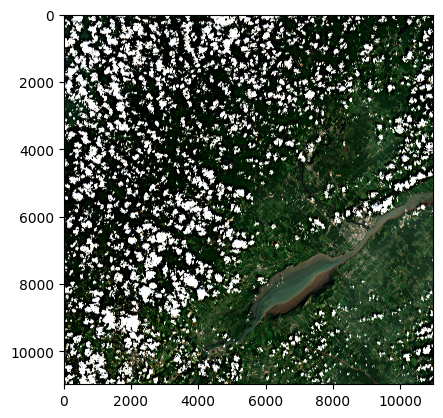

In [21]:
arr_rgb, dmin, dmax = utils.rgb_render(bands, bands=[2,1,0], 
                                 dmin=np.array([0., 0., 0.]), 
                                 dmax=np.array([0.2,0.2,0.2]))
pyplot.imshow(arr_rgb)

## Reading to xarray Dataset

The ```xarray``` library provides a nice decoration of ```numpy``` arrays for even more abstraction:

In [22]:
xrds = dataset.read_as_xarray(bands=sentinel2.Sentinel2.GROUP_10M)

In [23]:
print(xrds)

<xarray.Dataset>
Dimensions:  (t: 1, y: 10980, x: 10980)
Coordinates:
  * t        (t) datetime64[ns] 2023-07-19
  * x        (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
  * y        (y) float64 5.2e+06 5.2e+06 5.2e+06 ... 5.09e+06 5.09e+06 5.09e+06
Data variables:
    B2       (t, y, x) float32 0.0082 0.0077 0.0084 ... 0.6856 0.7032 0.719
    B3       (t, y, x) float32 0.0016 0.0029 0.0023 ... 0.6288 0.6435 0.6432
    B4       (t, y, x) float32 0.0011 0.0013 0.0018 ... 0.6315 0.6635 0.6846
    B8       (t, y, x) float32 0.0 0.0 0.0 0.0 ... 0.6293 0.6493 0.6568 0.6606
    SAT      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    CLM      (t, y, x) uint8 0 0 0 0 0 0 0 0 ... 139 139 131 131 131 131 131 131
    EDG      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    MG2      (t, y, x) uint8 1 1 1 1 1 1 1 1 1 1 1 1 ... 2 2 2 2 2 2 2 2 2 2 2 2
Attributes:
    tile:     18TXS
    type:     FRE
    crs:      EPSG:32618


The created datasets contains several variables, with the requested bands and masks:

In [24]:
xrds.data_vars

Data variables:
    B2       (t, y, x) float32 0.0082 0.0077 0.0084 ... 0.6856 0.7032 0.719
    B3       (t, y, x) float32 0.0016 0.0029 0.0023 ... 0.6288 0.6435 0.6432
    B4       (t, y, x) float32 0.0011 0.0013 0.0018 ... 0.6315 0.6635 0.6846
    B8       (t, y, x) float32 0.0 0.0 0.0 0.0 ... 0.6293 0.6493 0.6568 0.6606
    SAT      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    CLM      (t, y, x) uint8 0 0 0 0 0 0 0 0 ... 139 139 131 131 131 131 131 131
    EDG      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    MG2      (t, y, x) uint8 1 1 1 1 1 1 1 1 1 1 1 1 ... 2 2 2 2 2 2 2 2 2 2 2 2

Those variables are indexed with 3 sets of coordinates: x coordinates, y coordinates and time coordinates:

In [25]:
xrds.coords

Coordinates:
  * t        (t) datetime64[ns] 2023-07-19
  * x        (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
  * y        (y) float64 5.2e+06 5.2e+06 5.2e+06 ... 5.09e+06 5.09e+06 5.09e+06

The time coordinate has only a single value (since a dataset represents one acquisition date) but it would be very easy to stack several datasets together along the time dimension.

It is rather easy to use ```xarray``` to derive new variables:

In [26]:
ndvi = (xrds.B8-xrds.B4)/(1e-6 + xrds.B8 + xrds.B4)
print(ndvi)

<xarray.DataArray (t: 1, y: 10980, x: 10980)>
array([[[-0.99909174, -0.99923134, -0.9994447 , ...,  0.99294466,
          0.9999978 ,  0.99999785],
        [-0.9985735 , -0.99800396, -0.99800396, ...,  0.9976661 ,
          0.99999756,  0.9999976 ],
        [-0.99800396, -0.990099  ,  0.        , ...,  0.9867933 ,
          0.9931169 ,  0.9999975 ],
        ...,
        [-0.9988901 ,  0.        ,  0.        , ...,  0.09089588,
          0.08068178,  0.08191217],
        [ 0.        ,  0.        ,  0.        , ...,  0.06041281,
          0.06204243,  0.06218067],
        [ 0.        ,  0.        ,  0.99994284, ...,  0.01389753,
         -0.00507463, -0.01784119]]], dtype=float32)
Coordinates:
  * t        (t) datetime64[ns] 2023-07-19
  * x        (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
  * y        (y) float64 5.2e+06 5.2e+06 5.2e+06 ... 5.09e+06 5.09e+06 5.09e+06


Of course, one can always access the underlying ```numpy``` arrays:

In [27]:
ndvi.values

array([[[-0.99909174, -0.99923134, -0.9994447 , ...,  0.99294466,
          0.9999978 ,  0.99999785],
        [-0.9985735 , -0.99800396, -0.99800396, ...,  0.9976661 ,
          0.99999756,  0.9999976 ],
        [-0.99800396, -0.990099  ,  0.        , ...,  0.9867933 ,
          0.9931169 ,  0.9999975 ],
        ...,
        [-0.9988901 ,  0.        ,  0.        , ...,  0.09089588,
          0.08068178,  0.08191217],
        [ 0.        ,  0.        ,  0.        , ...,  0.06041281,
          0.06204243,  0.06218067],
        [ 0.        ,  0.        ,  0.99994284, ...,  0.01389753,
         -0.00507463, -0.01784119]]], dtype=float32)

# Advanced read

In this section, examples will be demonstrated with ```read_as_xarray(...)``` but one can achieve similar operations with ```read_as_numpy(...)```.

## Reading a spatial subset

The ```region``` argument accepts a ```rio.coords.BoundingBox``` object representing a geo-referenced bounding-box in the given ```crs``` (default to input image ```crs```):

In [29]:
dataset.bounds

BoundingBox(left=600000.0, bottom=5090220.0, right=709800.0, top=5200020.0)

In [30]:
georoi = rio.coords.BoundingBox(650000.0, 5100000.0, 680000.0, 5150000.0) # left, bottom, right, top

In [32]:
print(dataset.read_as_xarray(sentinel2.Sentinel2.GROUP_10M,
                             bounds=georoi))

<xarray.Dataset>
Dimensions:  (t: 1, y: 5000, x: 3000)
Coordinates:
  * t        (t) datetime64[ns] 2023-07-19
  * x        (x) float64 6.5e+05 6.5e+05 6.5e+05 ... 6.8e+05 6.8e+05 6.8e+05
  * y        (y) float64 5.15e+06 5.15e+06 5.15e+06 ... 5.1e+06 5.1e+06 5.1e+06
Data variables:
    B2       (t, y, x) float32 0.0 0.0 0.0 0.0 ... 0.0161 0.0152 0.0138 0.0144
    B3       (t, y, x) float32 0.0152 0.013 0.0106 ... 0.0409 0.0393 0.0397
    B4       (t, y, x) float32 0.0 0.0 0.0 0.0 ... 0.0152 0.0143 0.0139 0.0131
    B8       (t, y, x) float32 0.4124 0.4471 0.382 ... 0.4864 0.4951 0.5193
    SAT      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    CLM      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    EDG      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    MG2      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
Attributes:
    tile:     18TXS
    type:     FRE
    crs:      EPSG:32618


## Read bands with different resolutions, and changing resolution

All bands are resampled to the target resolution set by the ```resolution``` argument, which defaults to 10m. The interpolation algorithm can be set using the ```algorithm``` keyword and selected among the algorithm available in gdal/rasterio: https://rasterio.readthedocs.io/en/latest/api/rasterio.enums.html#rasterio.enums.Resampling (default is ```rio.enums.Resampling.cubic```).

In [33]:
print(dataset.read_as_xarray([sentinel2.Sentinel2.B2, sentinel2.Sentinel2.B6, sentinel2.Sentinel2.B11], # A 10m, a 20m and a 60m bands 
                       resolution=10, # The target resolution
                       bounds=georoi,
                       algorithm=rio.enums.Resampling.bilinear))

<xarray.Dataset>
Dimensions:  (t: 1, y: 5000, x: 3000)
Coordinates:
  * t        (t) datetime64[ns] 2023-07-19
  * x        (x) float64 6.5e+05 6.5e+05 6.5e+05 ... 6.8e+05 6.8e+05 6.8e+05
  * y        (y) float64 5.15e+06 5.15e+06 5.15e+06 ... 5.1e+06 5.1e+06 5.1e+06
Data variables:
    B2       (t, y, x) float32 0.0 0.0 0.0 0.0 ... 0.0161 0.0152 0.0138 0.0144
    B6       (t, y, x) float32 0.3192 0.3163 0.2955 ... 0.3949 0.3984 0.4043
    B11      (t, y, x) float32 0.1867 0.1824 0.1726 ... 0.1715 0.1699 0.1686
    SAT      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    CLM      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    EDG      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    MG2      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
Attributes:
    tile:     18TXS
    type:     FRE
    crs:      EPSG:32618


One can of course set a lower target resolution and change the interpolation algorithm accordingly:

In [34]:
print(dataset.read_as_xarray([sentinel2.Sentinel2.B2, sentinel2.Sentinel2.B6, sentinel2.Sentinel2.B11], # A 10m, a 20m and a 60m bands 
                             resolution=60, # The target resolution
                             bounds=georoi,
                             algorithm=rio.enums.Resampling.average))

<xarray.Dataset>
Dimensions:  (t: 1, y: 833, x: 500)
Coordinates:
  * t        (t) datetime64[ns] 2023-07-19
  * x        (x) float64 6.5e+05 6.501e+05 6.502e+05 ... 6.799e+05 6.8e+05
  * y        (y) float64 5.15e+06 5.15e+06 5.15e+06 ... 5.1e+06 5.1e+06 5.1e+06
Data variables:
    B2       (t, y, x) float32 0.0006 0.0016 0.0011 ... 0.0146 0.014 0.0147
    B6       (t, y, x) float32 0.291 0.2635 0.1832 ... 0.3418 0.3407 0.3766
    B11      (t, y, x) float32 0.1772 0.1701 0.1115 ... 0.1629 0.1638 0.1671
    SAT      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    CLM      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 ... 33 33 33 0 0 0 0 0 0 0 0
    EDG      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    MG2      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 8 8 8 8 0 0 0 0 0 0 0 0
Attributes:
    tile:     18TXS
    type:     FRE
    crs:      EPSG:32618


## Changing projection and sampling grid

The ```crs``` argument allows to resample the data into a different Coordinates Reference System  upon reading:

In [35]:
print(dataset.read_as_xarray(sentinel2.Sentinel2.GROUP_10M, crs='epsg:2154')) # Lambert93 EPSG code

<xarray.Dataset>
Dimensions:  (t: 1, y: 10980, x: 10980)
Coordinates:
  * t        (t) datetime64[ns] 2023-07-19
  * x        (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
  * y        (y) float64 5.2e+06 5.2e+06 5.2e+06 ... 5.09e+06 5.09e+06 5.09e+06
Data variables:
    B2       (t, y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    B3       (t, y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    B4       (t, y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    B8       (t, y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    SAT      (t, y, x) uint8 240 240 240 240 240 240 ... 240 240 240 240 240 240
    CLM      (t, y, x) uint8 240 240 240 240 240 240 ... 240 240 240 240 240 240
    EDG      (t, y, x) uint8 240 240 240 240 240 240 ... 240 240 240 240 240 240
    MG2      (t, y, x) uint8 240 240 240 240 240 240 ... 240 240 240 240 240 240
Attributes:
    tile:     18TXS
    type:     FRE
    crs:      epsg:2154


One can also change the image sampling grid by overloading the geographic bounds:

In [36]:
newbounds = rio.coords.BoundingBox(399965.0, 4690205.0, 401965.0, 4692205.0) # left, bottom, right, top

In [37]:
print(dataset.read_as_xarray(sentinel2.Sentinel2.GROUP_10M, bounds=newbounds))

<xarray.Dataset>
Dimensions:  (t: 1, y: 200, x: 200)
Coordinates:
  * t        (t) datetime64[ns] 2023-07-19
  * x        (x) float64 4e+05 4e+05 4e+05 4e+05 ... 4.019e+05 4.02e+05 4.02e+05
  * y        (y) float64 4.692e+06 4.692e+06 4.692e+06 ... 4.69e+06 4.69e+06
Data variables:
    B2       (t, y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    B3       (t, y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    B4       (t, y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    B8       (t, y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    SAT      (t, y, x) uint8 240 240 240 240 240 240 ... 240 240 240 240 240 240
    CLM      (t, y, x) uint8 240 240 240 240 240 240 ... 240 240 240 240 240 240
    EDG      (t, y, x) uint8 240 240 240 240 240 240 ... 240 240 240 240 240 240
    MG2      (t, y, x) uint8 240 240 240 240 240 240 ... 240 240 240 240 240 240
Attributes:
    tile:     18TXS
    type:     FRE
    crs:      EPSG:32618


***Note:*** This is different from using the region keyword which only does a subsetting. The ```bounds``` argument allows to modify the image sampling grid to match the grid of another image for instance.

## Using StackReg offsets

```StackReg``` provides offsets to apply to the image origin in order to getter better multi-temporal registration. Those offsets can be passed to the ```Sentinel2``` dataset constructor:

In [38]:
dataset = sentinel2.Sentinel2('/work/datalake/S2-L2A-THEIA/18TXS/2023/07/19/SENTINEL2B_20230719-160022-982_L2A_T18TXS_C_V3-1/', offsets=[-1.5, 2.5]) # x and y offsets in meters